In [1]:
import pandas as pd
import numpy as np
from itertools import chain
import patsy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from lifelines.utils import datetimes_to_durations
from lifelines import CoxPHFitter
%matplotlib inline

In [2]:
sample = pd.read_table('/psych/genetics_data/ccarey/UKBB/ukb_files/ukb_whitebritish.txt',sep=" ",index_col="IID")
with open("/stanley/genetics/datasets/ukb31063/ukb31063.withdrawn_participants.20210809.csv","r") as f:
        withdraw = f.read().split()
final_sample = np.setdiff1d(sample.index,withdraw)

In [3]:
rawcols_baseline = pd.read_table('/stanley/robinson/ccarey/UKBB/ukb_files/ukb31063.raw_phenotypes.tsv',nrows=0)

In [4]:
mycols_baseline = ["eid","53-0.0",'21003-0.0','105010-0.0', '105010-1.0', '105010-2.0', '105010-3.0', '105010-4.0','20400-0.0','22500-0.0','3894-0.0',"3992-0.0","3627-0.0","2966-0.0","3786-0.0","3761-0.0","2976-0.0","4689-0.0","4700-0.0","5945-0.0","20433-0.0"]

In [5]:
mycol_labels_baseline = ["sample", "age_at_baseline","date_baseline","date_diet1","date_diet2","date_diet3","date_diet4","date_mhq","date_work","age_heartattack","age_emphysema","age_angina","age_hypertension","age_asthma","age_hayfever","age_diabetes","age_glaucoma","age_cataract","age_eyeother","age_depression_mhq"]

In [6]:
coldict_baseline = dict(zip(mycols_baseline,mycol_labels_baseline))

In [7]:
raw_baseline = pd.read_table('/stanley/robinson/ccarey/UKBB/ukb_files/ukb31063.raw_phenotypes.tsv',usecols=mycols_baseline,index_col="eid",dtype=object)

In [8]:
mycols_birth = ["eid","34-0.0","52-0.0"]

In [9]:
mycol_labels_birth = ["sample", "birth_year", "birth_month"]

In [10]:
coldict_birth = dict(zip(mycols_birth,mycol_labels_birth))

In [11]:
birth = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/mortality/ukb41114.csv',usecols=mycols_birth,index_col="eid")

In [12]:
death = pd.read_table('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/mortality/ukb31063.death.20211215.txt',usecols=["eid","dsource","date_of_death"],index_col="eid")

In [13]:
dates_raw=raw_baseline[["53-0.0","105010-0.0","105010-1.0","105010-2.0","105010-3.0","105010-4.0","20400-0.0","22500-0.0"]]

In [14]:
dates = dates_raw.apply(lambda x: pd.to_datetime(x).dt.date,axis=1)

In [15]:
t0array = pd.DataFrame(dates.apply(lambda x: [y for y in list(x[:]) if not pd.isna(y)],axis=1))

In [16]:
t0array["t0"] = t0array[0].apply(lambda x: max(x))

In [17]:
covs = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/to_gwas/full_covs.csv",sep=",",index_col="userId")
covs.isFemale = covs.isFemale.astype(int)

In [18]:
fs_rescored = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/mortality/FS_newcode_full_semifinal_ind_rescored.csv').set_index("s")

In [19]:
fs_ind = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/FS_newcode_full_semifinal_ind.csv').set_index("s")
#wt_ind = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/WLSweight_newcode_full_semifinal_ind.csv').set_index("s")
misscor_ind = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/MissCor_newcode_full_semifinal_ind.csv').set_index("s")

In [20]:
fs_dep = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/FS_newcode_full_semifinal.csv').set_index("s")
wt_dep = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/WLSweight_newcode_full_semifinal.csv').set_index("s")
misscor_dep = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/MissCor_newcode_full_semifinal.csv').set_index("s")

In [21]:
fs_rescored[misscor_ind<np.sqrt(0.8)] = np.nan
fs_rescored[misscor_dep<np.sqrt(0.8)] = np.nan
fs_rescored.f27[misscor_dep.f27<np.sqrt(0.9)] = np.nan
fs_rescored[fs_dep.isna()] = np.nan

In [22]:
fs_rescored["f4"] = fs_rescored.f4*-1
fs_rescored["f10"] = fs_rescored.f10*-1
fs_rescored["f14"] = fs_rescored.f14*-1
fs_rescored["f19"] = fs_rescored.f19*-1
fs_rescored["f23"] = fs_rescored.f23*-1
fs_rescored["f24"] = fs_rescored.f24*-1
fs_rescored["f36"] = fs_rescored.f36*-1

In [23]:
toplot = pd.DataFrame(index=fs_rescored.columns,columns=["hr","hr_lower","hr_upper","p","n"])

In [24]:
for factor in fs_rescored.columns:
    print(factor)
    to_analyze_htn = pd.DataFrame(fs_rescored.dropna(subset=[factor])[factor]).join(covs,how="left").join(birth,how="left").join(death,how="left").join(raw_baseline,how="left").join(t0array["t0"],how="left")
    to_analyze_htn["start"] = pd.to_datetime(to_analyze_htn["t0"])
    to_analyze_htn["end"] = pd.to_datetime(to_analyze_htn["date_of_death"],format='%d/%m/%Y')
    to_analyze_htn = to_analyze_htn[~((to_analyze_htn.end - to_analyze_htn.start).dt.days<0)]
    T, E = datetimes_to_durations(to_analyze_htn.start, to_analyze_htn.end,fill_date=datetime.datetime(2021, 9, 30))
    to_analyze_htn["T"] = T
    to_analyze_htn["E"] = E
    to_analyze_htn["date_baseline"] = pd.to_datetime(to_analyze_htn["53-0.0"])
    to_analyze_htn["days_from_baseline"] = (to_analyze_htn.start - to_analyze_htn.date_baseline).dt.days
    formodel = to_analyze_htn[[factor,'54_10003','54_11001', '54_11002', '54_11003', '54_11004', '54_11005', '54_11006', '54_11007', '54_11008', '54_11009', '54_11010','54_11011', '54_11012', '54_11013', '54_11016', '54_11017', '54_11018','54_11020', '54_11021', '54_11022', '54_11023','PC1', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15','PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5','PC6', 'PC7', 'PC8', 'PC9', 'age', 'age_isFemale', 'age_squared','age_squared_isFemale', 'isFemale',"days_from_baseline","T","E"]]
    formodel = formodel[formodel.columns[formodel.var()!=0]]
    cph = CoxPHFitter()
    temp = cph.fit(formodel, 'T', event_col='E')
    toplot.loc[factor,"hr"] = temp.hazard_ratios_[0]
    toplot.loc[factor,["hr_lower","hr_upper"]] = np.exp(temp.confidence_intervals_).loc[factor].values
    toplot.loc[factor,"p"] = temp.summary.p[0]
    toplot.loc[factor,"n"] = temp._n_examples
    #cph.print_summary()
    #break

f1


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f10


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f11


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f12


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f13


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f14


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f15


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f16


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f17


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f18


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f19


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f2


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f20


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f21


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f22


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f23


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f24


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f25


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f26


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f27


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f28


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f29


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f3


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f30


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f31


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f32


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f33


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f34


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f35


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f36


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f4


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f5


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f6


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f7


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f9


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [25]:
bonf = 0.05/35

In [26]:
toplot.loc[toplot.p<bonf,"alpha"] = 1

In [27]:
toplot.loc[toplot.p>bonf,"alpha"] = 0.25

In [28]:
all_h2_rg = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/all_h2_rg.tsv",index_col="factor")
all_h2_rg["h2_lower"] = all_h2_rg["h2_full"]-all_h2_rg["h2_se_full"]
all_h2_rg["h2_upper"] = all_h2_rg["h2_full"]+all_h2_rg["h2_se_full"]
all_h2_rg["h2"] = all_h2_rg["h2_full"]

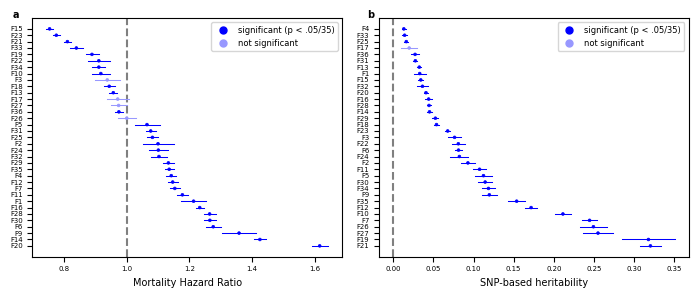

In [29]:
fig = plt.figure(figsize=(7.086, 3))
# fig = plt.figure(figsize=(3.464, 7.086))

fig.add_subplot(1,2,1)
toplot = toplot.sort_values("hr")
toplot["y"] = list(range(1,toplot.shape[0]+1))[::-1]
toplot.loc[toplot.p<bonf,"color"] = "blue"
toplot.loc[toplot.p>bonf,"color"] = "#9898FF"

#plt.scatter(x=toplot.hr,y=toplot.y,facecolor="white",marker="s",s=200,edgecolor="blue",zorder=2)
plt.scatter(x=toplot.hr,y=toplot.y,color=toplot['color'],marker="o",s=4,zorder=2,linewidth=0.5)
ax=plt.gca()
#for i, txt in enumerate(toplot.index):
#    ax.annotate(txt[1:], (toplot.hr.tolist()[i], toplot.y.tolist()[i]),ha="center",va="center",zorder=3,fontsize=5,fontweight="bold")
plt.yticks(range(1,len(toplot.hr)+1), toplot.index[::-1])
plt.xlabel("Mortality Hazard Ratio",fontsize=7)
for item in toplot.index:
    lower = toplot.loc[item,"hr_lower"]
    upper = toplot.loc[item,"hr_upper"]
    yval = toplot.loc[item,"y"]
    plt.plot([lower,upper],[yval,yval],color=toplot.loc[item,"color"],zorder=1,linewidth=0.75)
plt.axvline(x=1,color="gray",linestyle="--",zorder=0)
ax.axes.yaxis.set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_yticklabels([str(x).upper() for x in toplot.index.tolist()[::-1]], fontsize=5)

handlelist = [plt.plot([], marker="o", ls="", color=color, markersize=5)[0] for color in toplot["color"].unique()]
plt.legend(handlelist,['significant (p < .05/35)','not significant'],loc='upper right', fontsize=6)


fig.add_subplot(1,2,2)
toplot2 = all_h2_rg.sort_values("h2")
toplot2["y"] = list(range(1,toplot2.shape[0]+1))[::-1]
toplot2["color"] = "blue"
toplot2.loc["f17","color"] = "#9898FF"
#plt.scatter(x=toplot.hr,y=toplot.y,facecolor="white",marker="s",s=200,edgecolor="blue",zorder=2)
scatter = plt.scatter(x=toplot2.h2,y=toplot2.y,color=toplot2["color"],marker="o",s=4,zorder=2,linewidth=0.5)
ax=plt.gca()
#for i, txt in enumerate(toplot2.index):
#    ax.annotate(txt[1:], (toplot2.h2.tolist()[i], toplot2.y.tolist()[i]),ha="center",va="center",zorder=3,fontsize=5,fontweight="bold")
plt.yticks(range(1,len(toplot2.h2)+1), toplot2.index[::-1])
plt.xlabel("SNP-based heritability",fontsize=7)
for item in toplot2.index:
    lower = toplot2.loc[item,"h2_lower"]
    upper = toplot2.loc[item,"h2_upper"]
    yval = toplot2.loc[item,"y"]
    plt.plot([lower,upper],[yval,yval],color=toplot2.loc[item,"color"],zorder=1,linewidth=0.75)
plt.axvline(x=0,color="gray",linestyle="--",zorder=0)
ax.axes.yaxis.set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_yticklabels([str(x).upper() for x in toplot2.index.tolist()[::-1]], fontsize=5)

handlelist = [plt.plot([], marker="o", ls="", color=color, markersize=5)[0] for color in toplot2["color"].unique()]
plt.legend(handlelist,['significant (p < .05/35)','not significant'],loc='upper right', fontsize=6)

fig.text(0.03, 0.95, 'a', ha='center', fontsize=7,fontweight='bold')
fig.text(0.53, 0.95, 'b', ha='center', fontsize=7,fontweight='bold')

fig.tight_layout()

plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/figures_RKWchecklist/Figure2_journal_RKW.pdf",format="pdf") #,bbox_inches="tight"
# plt.show()